In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import xtrack as xt
import xobjects as xo
import matplotlib.pyplot as plt

In [3]:
line = xt.Line.from_json('pimms_02_tuned.json')
line.build_tracker()

Loading line from dict:   0%|          | 0/221 [00:00<?, ?it/s]

Done loading line from dict.           
Found suitable prebuilt kernel `default_only_xtrack`.


### Build a matched beam distribution

In [4]:
num_particles = 3000
beam_intensity = 1e10 # p+

# Generate Gaussian distribution in normalized phase space
x_norm = np.random.normal(size=num_particles)
px_norm = np.random.normal(size=num_particles)
y_norm = np.random.normal(size=num_particles)
py_norm = np.random.normal(size=num_particles)

# Generate Gaussian momentum distribution (rms spread 5e-4)
delta = 5e-4 * np.random.normal(size=num_particles)

# Assemble Particles object
particles = line.build_particles(
    x_norm=x_norm, px_norm=px_norm, 
    y_norm=y_norm, py_norm=py_norm,
    delta=delta,
    method='4d',
    weight=beam_intensity / num_particles,
    nemitt_x=1.5e-6, nemitt_y=1e-6,
)

# save initial state
p0 = particles.copy()

Found suitable prebuilt kernel `only_xtrack_frozen_energy`.


### Define time-dependent bevior of extraction sextupoles

In [5]:
line.functions['fun_xsext'] = xt.FunctionPieceWiseLinear(x=[0, 0.1e-3, 0.5e-3], y=[0, 0, 1.])

line.vars['kse1'] *= line.functions['fun_xsext'](line.vars['t_turn_s'])
line.vars['kse2'] *= line.functions['fun_xsext'](line.vars['t_turn_s'])

# Inspect the expression
line.vars['kse1']._expr

(4.948275143446286 * f['fun_xsext'](vars['t_turn_s']))

### Set realistic septum aperture

In [6]:
line['septum_aperture'].max_x = 0.035

### Switch to multithreaded context to gain speed

In [7]:
line.discard_tracker()
ctx = xo.ContextCpu(omp_num_threads=4)
line.build_tracker(_context=ctx)

Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.


### Define quantities to be logged during tracking

User can provide arbitrary functions executed at every turn (output is automatically logged).

In [8]:
# User-defined quantity to be logged
def measure_intensity(line, particles):
    mask_alive = particles.state > 0
    intensity = np.sum(particles.weight[mask_alive])
    return intensity

log = xt.Log('kse1', 'kse2',              # vars to be logged
             intensity=measure_intensity) # user-defined function to be logged

### Enable time-dependent vars update for tracking

In [9]:
line.enable_time_dependent_vars = True

### Track!

In [10]:
line.track(particles, num_turns=5000, with_progress=True,
           log=log)

Tracking:   0%|          | 0/5000 [00:00<?, ?it/s]

### Plot logged quantities

<IPython.core.display.Javascript object>


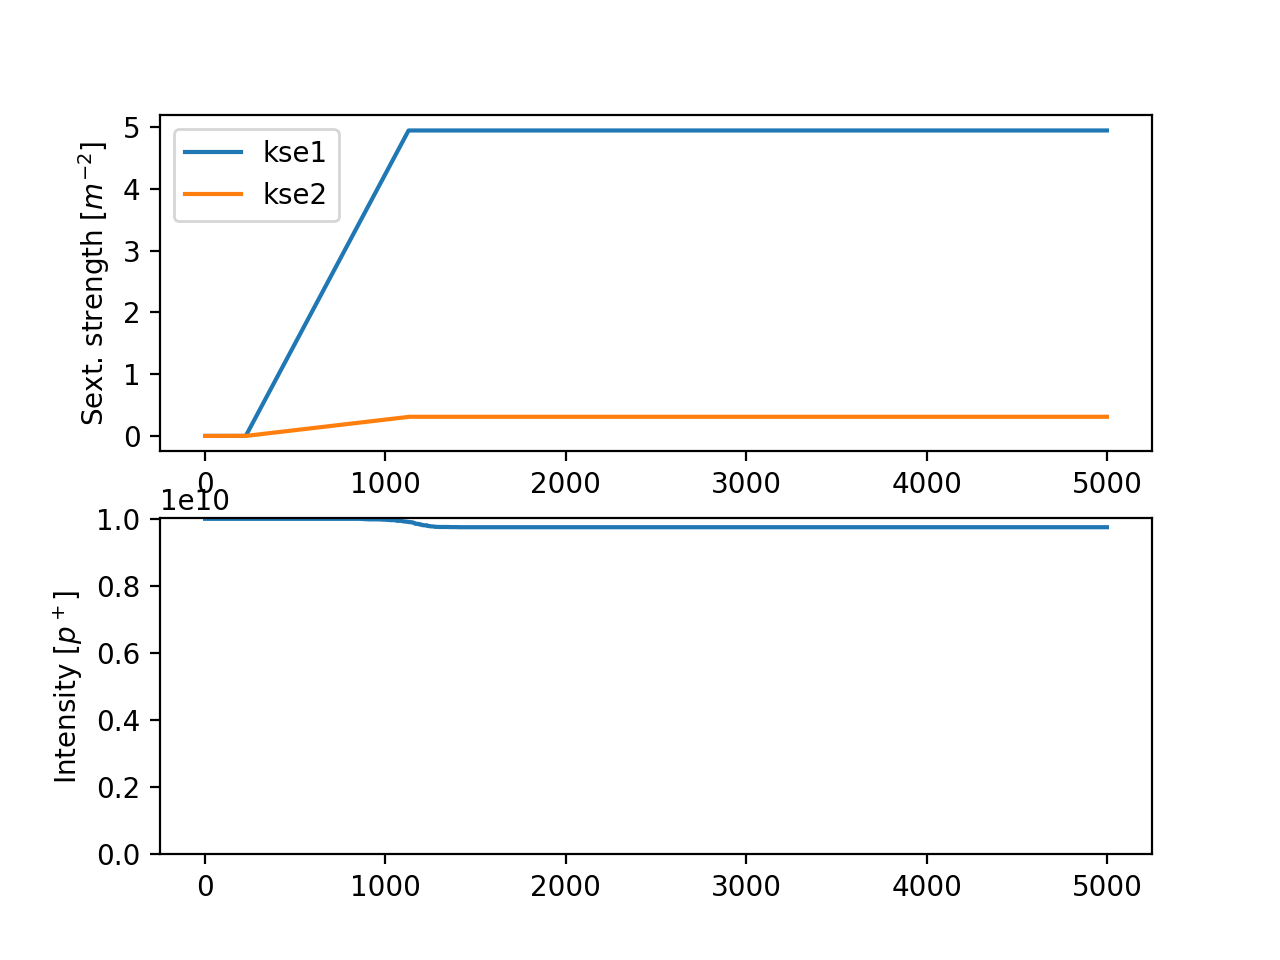

Text(0, 0.5, 'Intensity [$p^+$]')

In [11]:
plt.figure()

ax1 = plt.subplot(2,1,1)
plt.plot(line.log_last_track['kse1'], label='kse1')
plt.plot(line.log_last_track['kse2'], label='kse2')
plt.ylabel('Sext. strength [$m^{-2}$]')
plt.legend()

ax2 = plt.subplot(2,1,2, sharex=ax1)
plt.plot(line.log_last_track['intensity'])
plt.ylim(bottom=0)
plt.ylabel('Intensity [$p^+$]')

<IPython.core.display.Javascript object>


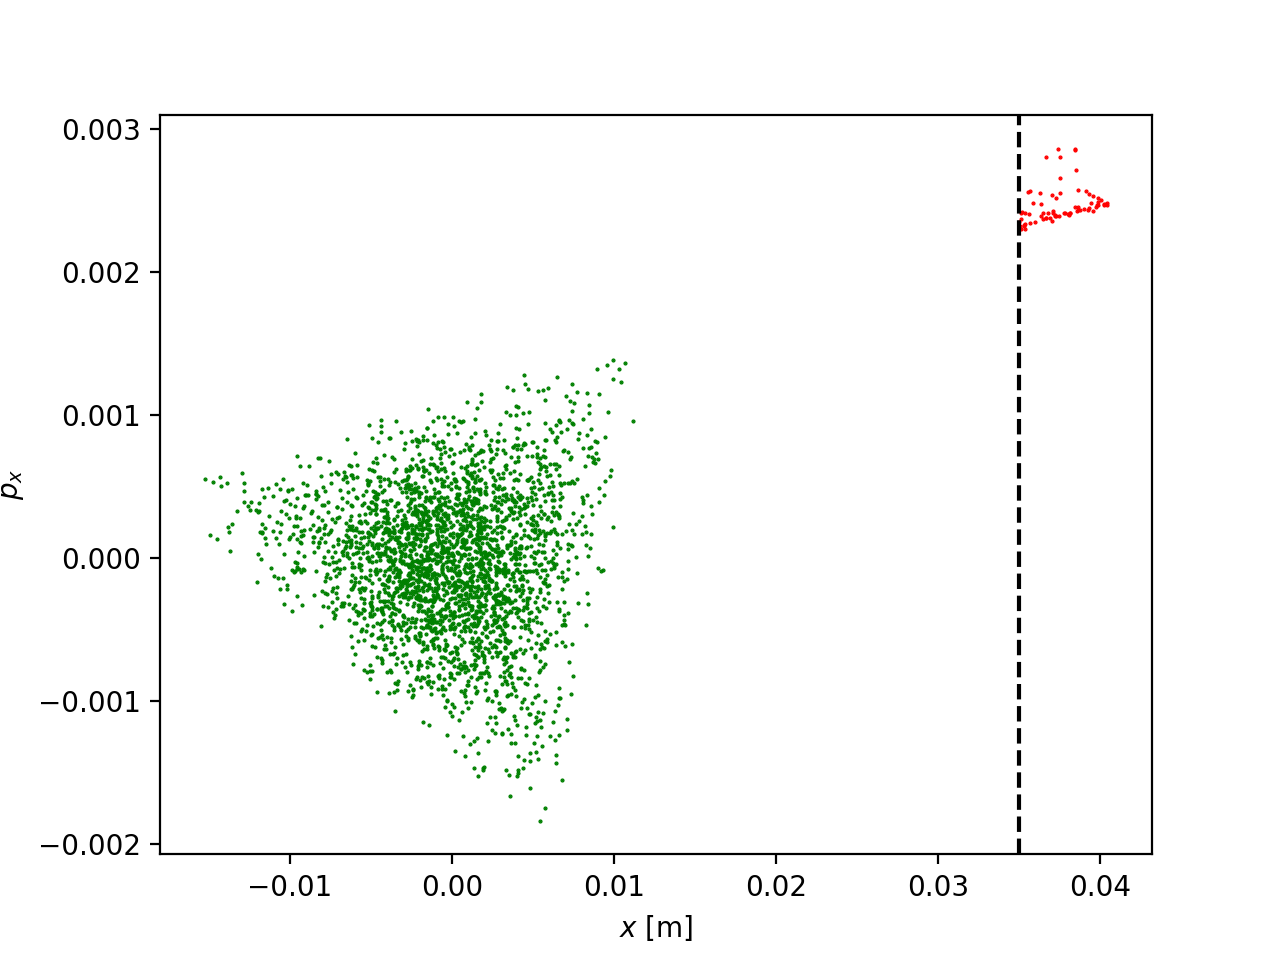

In [12]:
plt.figure()
mask_alive = particles.state>0
mask_lost = ~mask_alive
plt.plot(particles.x[mask_alive], particles.px[mask_alive],
         '.', markersize=1, color='green', label='circulating')
plt.plot(particles.x[mask_lost], particles.px[mask_lost],
         '.', markersize=1, color='red', label='extracted')
plt.xlabel('$x$ [m]'); plt.ylabel('$p_x$')
plt.axvline(x=line['septum_aperture'].max_x, color='k', ls='--')
plt.show()

## Introduce transverse excitation to control the spill

We build a custom beam element that excites the beam with a white noise and adjusts the ampliude of the noise to keep the desired spill rate.

In [13]:
# Define new element type
class SpillExcitation:
    def __init__(self):
 
        self.amplitude = 5e-6

        self.target_rate = 1e10/ 10000 # Particles per turn
        self.gain = 1e-3
        self.n_ave = 100

        self._i_turn = 0
        self.intensity = []

    def track(self, p):
 
        p.px[p.state > 0] += (
            self.amplitude * np.random.normal(size=np.sum(p.state > 0)))
        
        self.intensity.append(np.sum(p.weight[p.state > 0]))
        if self._i_turn > self.n_ave:
        
            rate = (self.intensity[self._i_turn - self.n_ave] - self.intensity[self._i_turn]) / self.n_ave
            self.amplitude -= self.amplitude * self.gain * (rate - self.target_rate)/self.target_rate

        self._i_turn += 1

In [14]:
# Install the element
line.discard_tracker()
line.insert_element('spill_exc', SpillExcitation(), at_s=0)
line.build_tracker(_context=ctx)

Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.


In [15]:
# Reset simulation time
line.vars['t_turn_s'] = 0

In [16]:
# Back to initial particles distribution
p = p0.copy()

In [17]:
def get_exc_amplitude(line, p):
    return line['spill_exc'].amplitude

log = xt.Log('kse1', 'kse2',           # vars to be logged
    intensity=measure_intensity,       # user-defined functions to be logged
    excit_amplitude=get_exc_amplitude) 

In [18]:
### Track!

line.track(p, num_turns=10000, with_progress=True,
           log=log)

Tracking:   0%|          | 0/10000 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.


<IPython.core.display.Javascript object>


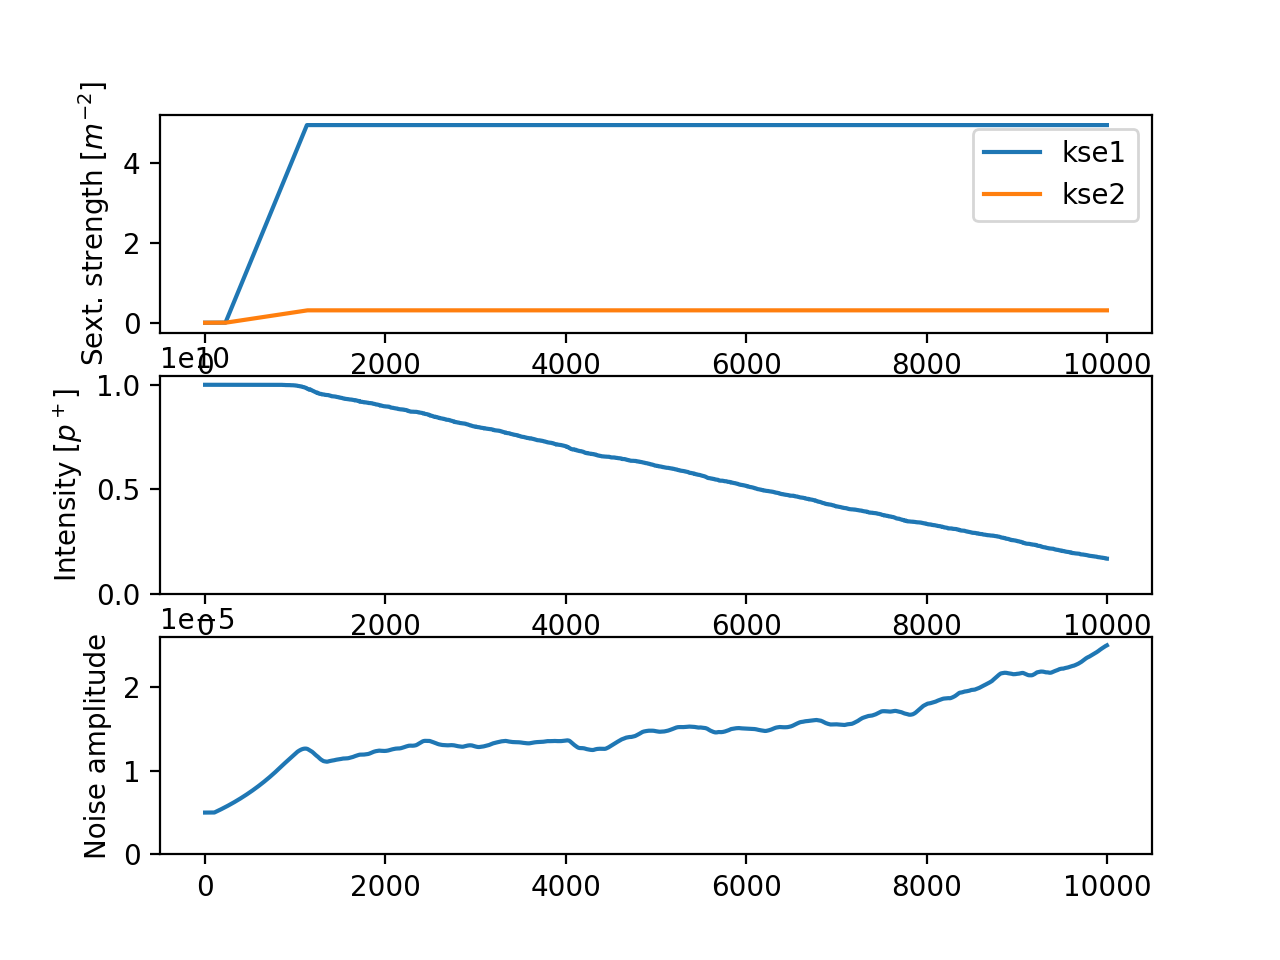

Text(0, 0.5, 'Noise amplitude')

In [19]:
plt.figure()

ax1 = plt.subplot(3,1,1)
plt.plot(line.log_last_track['kse1'], label='kse1')
plt.plot(line.log_last_track['kse2'], label='kse2')
plt.ylabel('Sext. strength [$m^{-2}$]')
plt.legend()

ax2 = plt.subplot(3,1,2, sharex=ax1)
plt.plot(line.log_last_track['intensity'])
plt.ylim(bottom=0)
plt.ylabel('Intensity [$p^+$]')

ax3 = plt.subplot(3,1,3, sharex=ax1)
plt.plot(line.log_last_track['excit_amplitude'])
plt.ylim(bottom=0)
plt.ylabel('Noise amplitude')